Pada project ini saya sebagai junior data analyst akan melanjutkan A/B testing terhadap data yang didapat dari international online store, yang mana data analyst sebelumnya sudah resign dengan meninggalkan A/B testing yang belum diselesaikan.

Tujuan dilakukan A/B test ini adalah untuk meningkatkan setidaknya ada peningkatan 10% dari masing-masing funnel dan setidaknya ada 6000 partisipan untuk A/B test ini. 

Pada tahapan awal saya akan mengimpor semua dataset yang ada, di project ini berjumlah 4 datasets yang disediakan, antara lain:
1. ab_project_marketing_events_us.csv yang berisikan kalender marketing event untuk tahun 2020
2. final_ab_events_upd_us.csv yang berisikan kegiatan pengguna baru dari December 7, 2020 sampai January 1, 2021
3. final_ab_new_users_upd_us.csv yang berisikan pengguna baru dari December 7-21, 2020
4. final_ab_participants_upd_us.csv yang berisikan partisipan dari test

dataset diatas tidak terdapat informasi tentang kualitas datanya, maka dari itu tahapan selanjutnya adalah melakukan prapemrosesan data untuk melihat bagaimana kualitas data tersebut

setelah dilakukan prapemrosesan data saya akan melakukan penggabungan dataset untuk mendapatkan dataset terkait partisipan tes ini, setelah mendapatkan dataset yang dibutuhkan saya akan mengecek apakah syarat yang dibutuhkan a/b testing sudah terpenuhi seperti ada perwakilan dari masing-masing kelompok, apakah ada partisipan yang berada di kedua grup dan sebaginya.
setelah itu melihat bagaimana grafik partisipan tes antar grup dan melakukan A/B test menggunakan metode ztest

In [155]:
# Mengimport library
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
from scipy import stats

## Pra Pemrosesan Data

In [156]:
try: 
    df_marketing = pd.read_csv('ab_project_marketing_events_us.csv')
    df_event = pd.read_csv('final_ab_events_upd_us.csv')
    df_users = pd.read_csv('final_ab_new_users_upd_us.csv')
    df_group = pd.read_csv('final_ab_participants_upd_us.csv')
    
except:
    df_marketing = pd.read_csv('/datasets/ab_project_marketing_events_us.csv')
    df_event = pd.read_csv('/datasets/final_ab_events_upd_us.csv')
    df_users = pd.read_csv('/datasets/final_ab_new_users_upd_us.csv')
    df_group = pd.read_csv('/datasets/final_ab_participants_upd_us.csv')

### Dataframe Marketing

In [157]:
df_marketing

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11
5,Black Friday Ads Campaign,"EU, CIS, APAC, N.America",2020-11-26,2020-12-01
6,Chinese New Year Promo,APAC,2020-01-25,2020-02-07
7,Labor day (May 1st) Ads Campaign,"EU, CIS, APAC",2020-05-01,2020-05-03
8,International Women's Day Promo,"EU, CIS, APAC",2020-03-08,2020-03-10
9,Victory Day CIS (May 9th) Event,CIS,2020-05-09,2020-05-11


In [158]:
df_marketing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 580.0+ bytes


terdapat kesalah tipe data pada objek datetime

In [159]:
# Membenarkan tipe data
df_marketing['start_dt'] = pd.to_datetime(df_marketing['start_dt'])
df_marketing['finish_dt'] = pd.to_datetime(df_marketing['finish_dt'])
df_marketing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   name       14 non-null     object        
 1   regions    14 non-null     object        
 2   start_dt   14 non-null     datetime64[ns]
 3   finish_dt  14 non-null     datetime64[ns]
dtypes: datetime64[ns](2), object(2)
memory usage: 580.0+ bytes


### Dataframe event

In [160]:
df_event

,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99
...,...,...,...,...
423756,245E85F65C358E08,2020-12-30 19:35:55,login,NaN
423757,9385A108F5A0A7A7,2020-12-30 10:54:15,login,NaN
423758,DB650B7559AC6EAC,2020-12-30 10:59:09,login,NaN
423759,F80C9BDDEA02E53C,2020-12-30 09:53:39,login,NaN


In [161]:
df_event.describe()

,details
count,60314.000000
mean,23.881219
std,72.228884
min,4.990000
25%,4.990000
50%,4.990000
75%,9.990000
max,499.990000


In [162]:
df_event.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 423761 entries, 0 to 423760
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     423761 non-null  object 
 1   event_dt    423761 non-null  object 
 2   event_name  423761 non-null  object 
 3   details     60314 non-null   float64
dtypes: float64(1), object(3)
memory usage: 12.9+ MB


sekilas yang terlihat, terdapat kesalahan pada datetime

In [163]:
# Membenarkan datetime
df_event['event_dt'] = pd.to_datetime(df_event['event_dt'])
df_event['datetime'] = df_event['event_dt'].dt.date
df_event['datetime'] = pd.to_datetime(df_event['datetime'])

In [164]:
## Mendalami nilai null
df_event['event_name'].value_counts()

event_name
login           182465
product_page    120862
purchase         60314
product_cart     60120
Name: count, dtype: int64

In [165]:
df_event.isna().sum()

user_id            0
event_dt           0
event_name         0
details       363447
datetime           0
dtype: int64

In [166]:
#melihat distribusi nilai kosong pada kolom details
df_event[df_event['details'].isna()]['event_name'].value_counts()

event_name
login           182465
product_page    120862
product_cart     60120
Name: count, dtype: int64

jika dilihat dari persebaran nilai null nya, memang benar jika kolom tersebut bernilai null. maka dengan penemuan tersebut nilai null yang ada akan dibiarkan

In [167]:
# Pemeriksaan nilai duplikat
df_event.duplicated().sum()

0

tidak terdapat nilai duplikat data dataframe event

### Dataframe users

In [168]:
df_users

,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone
...,...,...,...,...
58698,1DB53B933257165D,2020-12-20,EU,Android
58699,538643EB4527ED03,2020-12-20,EU,Mac
58700,7ADEE837D5D8CBBD,2020-12-20,EU,PC
58701,1C7D23927835213F,2020-12-20,EU,iPhone


In [169]:
df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58703 entries, 0 to 58702
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     58703 non-null  object
 1   first_date  58703 non-null  object
 2   region      58703 non-null  object
 3   device      58703 non-null  object
dtypes: object(4)
memory usage: 1.8+ MB


terdapat kesalahan tipe data pada kolom first_date

In [170]:
# Membenarkan kolom fristdate
df_users['first_date'] = pd.to_datetime(df_users['first_date'])

In [171]:
df_users['region'].value_counts()

region
EU           43396
N.America     9051
CIS           3130
APAC          3126
Name: count, dtype: int64

In [172]:
df_users['device'].value_counts()

device
Android    26159
PC         14845
iPhone     11902
Mac         5797
Name: count, dtype: int64

In [173]:
df_users.duplicated().sum()

0

### Dataframe Group

In [174]:
df_group

,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,4FF2998A348C484F,A,recommender_system_test
...,...,...,...
14520,1D302F8688B91781,B,interface_eu_test
14521,3DE51B726983B657,A,interface_eu_test
14522,F501F79D332BE86C,A,interface_eu_test
14523,63FBE257B05F2245,A,interface_eu_test


In [175]:
df_group.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14525 entries, 0 to 14524
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  14525 non-null  object
 1   group    14525 non-null  object
 2   ab_test  14525 non-null  object
dtypes: object(3)
memory usage: 340.6+ KB


In [176]:
df_group['group'].value_counts()

group
A    8214
B    6311
Name: count, dtype: int64

In [177]:
df_group['ab_test'].value_counts()

ab_test
interface_eu_test          10850
recommender_system_test     3675
Name: count, dtype: int64

In [178]:
df_group['user_id'].nunique()

13638

jikalau melihat technical description, partisipan tes sebanyak 6000 terpenuhi. dikarenakan kita memiliki sekitar 13000 partisipan untuk tes

In [179]:
df_group.groupby(['group', 'ab_test'])['user_id'].nunique()

group  ab_test                
A      interface_eu_test          5467
       recommender_system_test    2747
B      interface_eu_test          5383
       recommender_system_test     928
Name: user_id, dtype: int64

terdapat perbedaan jumlah data yang signifikan di bagian "recommender_system_test" dimana pada grup B perbedaannya sangat jauh sekali dengan group A

In [180]:
df_group.duplicated().sum()

0

## Analisis Data

In [181]:
# Menggabungkan semua dataframe

df_merge_all = df_event.merge(df_group, how= 'inner', on='user_id')
df_merge_all = df_merge_all.merge(df_users, how='inner', on='user_id')
df_merge_all['datetime'] = df_merge_all['event_dt'].dt.date
df_merge_all['datetime'] = pd.to_datetime(df_merge_all['datetime'])
df_merge_all['day'] = df_merge_all['datetime'].dt.dayofweek
df_merge_all

,user_id,event_dt,event_name,details,datetime,group,ab_test,first_date,region,device,day
0,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99,2020-12-07,B,interface_eu_test,2020-12-07,EU,iPhone,0
1,96F27A054B191457,2020-12-08 09:43:14,purchase,4.99,2020-12-08,B,interface_eu_test,2020-12-07,EU,iPhone,1
2,96F27A054B191457,2020-12-09 00:44:10,purchase,4.99,2020-12-09,B,interface_eu_test,2020-12-07,EU,iPhone,2
3,96F27A054B191457,2020-12-26 00:33:57,purchase,9.99,2020-12-26,B,interface_eu_test,2020-12-07,EU,iPhone,5
4,96F27A054B191457,2020-12-07 04:02:41,product_page,NaN,2020-12-07,B,interface_eu_test,2020-12-07,EU,iPhone,0
...,...,...,...,...,...,...,...,...,...,...,...
102833,40076B77CFC12421,2020-12-23 03:43:28,login,NaN,2020-12-23,B,interface_eu_test,2020-12-23,EU,iPhone,2
102834,40076B77CFC12421,2020-12-24 04:21:53,login,NaN,2020-12-24,B,interface_eu_test,2020-12-23,EU,iPhone,3
102835,40076B77CFC12421,2020-12-26 03:50:17,login,NaN,2020-12-26,B,interface_eu_test,2020-12-23,EU,iPhone,5
102836,301C602AF78BABAD,2020-12-23 10:39:25,login,NaN,2020-12-23,B,interface_eu_test,2020-12-23,EU,Android,2


In [211]:
df_merge_all.duplicated().sum()

0

In [182]:
# waktu awal dimulainya ab testing
df_merge_all['first_date'].min()

Timestamp('2020-12-07 00:00:00')

In [183]:
# Mencari hari-hari yang terdapat event promosi pada saat ab testing berlangsung
df_marketing[df_marketing['start_dt'] >= '2020-12-07']

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
10,CIS New Year Gift Lottery,CIS,2020-12-30,2021-01-07


terdapat 2 promosi saat ab testing berlangsung

In [184]:
# Region EU ketika event Christmas&New Year Promo berlangsung
df_merge_all[(df_merge_all['region'] == 'EU')\
             & (df_merge_all['datetime'] >= '2020-12-25') & (df_merge_all['datetime'] <= '2021-01-03')
            ]['user_id'].nunique()

3954

In [185]:
# Region N.America ketika event Christmas&New Year Promo berlangsung
df_merge_all[(df_merge_all['region'] == 'N.America')\
             & (df_merge_all['datetime'] >= '2020-12-25') & (df_merge_all['datetime'] <= '2021-01-03')
            ]['user_id'].nunique()

29

In [186]:
# Region CIS ketika event CIS New Year Gift Lottery berlangsung
df_merge_all[(df_merge_all['region'] == 'CIS')\
             & (df_merge_all['datetime'] >= '2020-12-30') & (df_merge_all['datetime'] <= '2021-01-07')
            ]['user_id'].nunique()

0

Terdapat 3954 user asal EU dan 29 user asal N.America yang melakukan interaksi pada saat marketing event berlangsung, yang mana ini tidak sesuai dengan dasar ab testing yang waktu analisa mengharuskan saat hari normal seperti biasanya (tidak ada event tertentu yang memicu kenaikan pada data)

### Study conversion at different stages of the funnel

In [187]:
df_merge_all.head()

,user_id,event_dt,event_name,details,datetime,group,ab_test,first_date,region,device,day
0,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99,2020-12-07,B,interface_eu_test,2020-12-07,EU,iPhone,0
1,96F27A054B191457,2020-12-08 09:43:14,purchase,4.99,2020-12-08,B,interface_eu_test,2020-12-07,EU,iPhone,1
2,96F27A054B191457,2020-12-09 00:44:10,purchase,4.99,2020-12-09,B,interface_eu_test,2020-12-07,EU,iPhone,2
3,96F27A054B191457,2020-12-26 00:33:57,purchase,9.99,2020-12-26,B,interface_eu_test,2020-12-07,EU,iPhone,5
4,96F27A054B191457,2020-12-07 04:02:41,product_page,NaN,2020-12-07,B,interface_eu_test,2020-12-07,EU,iPhone,0


In [188]:
# membuat berapa banyak user di event tertentu berdasarkan group dan testing name nya
data_new3 = (
    df_merge_all.drop(['event_dt'], axis=1)
    .groupby(['event_name','group','ab_test'], as_index =False)
    .agg({'user_id': 'nunique'})
)
data_new3 = data_new3.rename(columns={'user_id':'user'})
data_new3

,event_name,group,ab_test,user
0,login,A,interface_eu_test,5466
1,login,A,recommender_system_test,2747
2,login,B,interface_eu_test,5383
3,login,B,recommender_system_test,927
4,product_cart,A,interface_eu_test,1756
5,product_cart,A,recommender_system_test,824
6,product_cart,B,interface_eu_test,1812
7,product_cart,B,recommender_system_test,255
8,product_page,A,interface_eu_test,3639
9,product_page,A,recommender_system_test,1780


In [189]:
# memecah menjadi beberapa dataframe
df_a_interface = data_new3.query('group == "A" & ab_test == "interface_eu_test"')
df_a_recommender = data_new3.query('group == "A" & ab_test == "recommender_system_test"')

df_b_interface = data_new3.query('group == "B" & ab_test == "interface_eu_test"')
df_b_recommender = data_new3.query('group == "B" & ab_test == "recommender_system_test"')

In [190]:
#membuat kolom ratio pada masing-masing dataframe
df_a_interface['ratio'] = df_a_interface['user']/(df_a_interface['user'].max())
df_a_recommender['ratio'] = df_a_recommender['user']/(df_a_recommender['user'].max())
df_b_interface['ratio'] = df_b_interface['user']/(df_b_interface['user'].max())
df_b_recommender['ratio'] = df_b_recommender['user']/(df_b_recommender['user'].max())

C:\Users\Bayuu\AppData\Local\Temp\ipykernel_980\2526609963.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_a_interface['ratio'] = df_a_interface['user']/(df_a_interface['user'].max())
C:\Users\Bayuu\AppData\Local\Temp\ipykernel_980\2526609963.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_a_recommender['ratio'] = df_a_recommender['user']/(df_a_recommender['user'].max())
C:\Users\Bayuu\AppData\Local\Temp\ipykernel_980\2526609963.py:4: SettingWithCopyWarning: 
A value is trying to be set on a c

#### Testname interface

In [191]:
#group A (kontrol)
df_a_interface

,event_name,group,ab_test,user,ratio
0,login,A,interface_eu_test,5466,1.000000
4,product_cart,A,interface_eu_test,1756,0.321259
8,product_page,A,interface_eu_test,3639,0.665752
12,purchase,A,interface_eu_test,1931,0.353275


In [192]:
#group B (uji)
df_b_interface

,event_name,group,ab_test,user,ratio
2,login,B,interface_eu_test,5383,1.000000
6,product_cart,B,interface_eu_test,1812,0.336615
10,product_page,B,interface_eu_test,3527,0.655211
14,purchase,B,interface_eu_test,1782,0.331042


pada test name interface_eu_test tidak terdapat perbedaan yang signifikan, hanya berbeda 1-2% antara kedua grup dengan ratio purchase lebih rendah di grup B

#### testname recommender

In [193]:
df_a_recommender

,event_name,group,ab_test,user,ratio
1,login,A,recommender_system_test,2747,1.000000
5,product_cart,A,recommender_system_test,824,0.299964
9,product_page,A,recommender_system_test,1780,0.647980
13,purchase,A,recommender_system_test,872,0.317437


In [194]:
df_b_recommender

,event_name,group,ab_test,user,ratio
3,login,B,recommender_system_test,927,1.000000
7,product_cart,B,recommender_system_test,255,0.275081
11,product_page,B,recommender_system_test,523,0.564186
15,purchase,B,recommender_system_test,256,0.276160


pada testname recommender_system_test setelah ditelusuri bahwa kelompok B memiliki ratio lebih rendah daripada kelompok A. Kelompok B mengalamani penurunan 2-8% dibandingkan dengan kelompok A

### Is the number of events per user distributed equally among the samples?

In [195]:
df_merge_all.head()

,user_id,event_dt,event_name,details,datetime,group,ab_test,first_date,region,device,day
0,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99,2020-12-07,B,interface_eu_test,2020-12-07,EU,iPhone,0
1,96F27A054B191457,2020-12-08 09:43:14,purchase,4.99,2020-12-08,B,interface_eu_test,2020-12-07,EU,iPhone,1
2,96F27A054B191457,2020-12-09 00:44:10,purchase,4.99,2020-12-09,B,interface_eu_test,2020-12-07,EU,iPhone,2
3,96F27A054B191457,2020-12-26 00:33:57,purchase,9.99,2020-12-26,B,interface_eu_test,2020-12-07,EU,iPhone,5
4,96F27A054B191457,2020-12-07 04:02:41,product_page,NaN,2020-12-07,B,interface_eu_test,2020-12-07,EU,iPhone,0


In [196]:
df_merge_all.pivot_table(
index='user_id',
columns='event_name',
values='event_dt',
aggfunc='count').head(20)

event_name,login,product_cart,product_page,purchase
user_id,,,,
0002CE61FF2C4011,4.0,4.0,4.0,NaN
001064FEAAB631A1,6.0,NaN,6.0,NaN
0010A1C096941592,4.0,NaN,4.0,4.0
001E72F50D1C48FA,3.0,NaN,3.0,NaN
002412F1EB3F6E38,3.0,NaN,3.0,NaN
002540BE89C930FB,3.0,3.0,3.0,NaN
0031F1B5E9FBF708,2.0,NaN,NaN,2.0
003346BB64227D0C,3.0,NaN,NaN,NaN
00341D8401F0F665,4.0,NaN,NaN,NaN


jika dilihat dari sample data tersebut jumlah event per pengguna tidak terdistribusi secara merata. banyak user_id yang hanya melakukan 1 atau 2 event

### Are there users who are present in both samples?

In [197]:
df_double_group = df_merge_all.groupby('user_id')['group'].nunique().reset_index().sort_values(by='group', ascending= False)
df_double_group.head()

,user_id,group
9416,B06B45B7C3E5E721,2
12224,E594B711ADD81DD8,2
9004,A8C25A605F613665,2
3070,3A6D88AB973BD99D,2
564,0ADFFFE9C0D60092,2


In [198]:
df_double_group.query('group == 2').shape

(441, 2)

terdapat 441 user yang berada di kedua group (A dan B)

### How is the number of events distributed among days?

In [199]:
df_merge_all

,user_id,event_dt,event_name,details,datetime,group,ab_test,first_date,region,device,day
0,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99,2020-12-07,B,interface_eu_test,2020-12-07,EU,iPhone,0
1,96F27A054B191457,2020-12-08 09:43:14,purchase,4.99,2020-12-08,B,interface_eu_test,2020-12-07,EU,iPhone,1
2,96F27A054B191457,2020-12-09 00:44:10,purchase,4.99,2020-12-09,B,interface_eu_test,2020-12-07,EU,iPhone,2
3,96F27A054B191457,2020-12-26 00:33:57,purchase,9.99,2020-12-26,B,interface_eu_test,2020-12-07,EU,iPhone,5
4,96F27A054B191457,2020-12-07 04:02:41,product_page,NaN,2020-12-07,B,interface_eu_test,2020-12-07,EU,iPhone,0
...,...,...,...,...,...,...,...,...,...,...,...
102833,40076B77CFC12421,2020-12-23 03:43:28,login,NaN,2020-12-23,B,interface_eu_test,2020-12-23,EU,iPhone,2
102834,40076B77CFC12421,2020-12-24 04:21:53,login,NaN,2020-12-24,B,interface_eu_test,2020-12-23,EU,iPhone,3
102835,40076B77CFC12421,2020-12-26 03:50:17,login,NaN,2020-12-26,B,interface_eu_test,2020-12-23,EU,iPhone,5
102836,301C602AF78BABAD,2020-12-23 10:39:25,login,NaN,2020-12-23,B,interface_eu_test,2020-12-23,EU,Android,2


In [200]:
pivot_daily_event = df_merge_all.pivot_table(
    index= 'datetime',
    columns= ['ab_test','event_name','group'],
    values='user_id',
    aggfunc='nunique'
)
pivot_daily_event.head()

ab_test    interface_eu_test                                                 \
event_name             login        product_cart        product_page          
group                      A      B            A      B            A      B   
datetime                                                                      
2020-12-07             455.0  448.0        131.0  139.0        303.0  283.0   
2020-12-08             497.0  499.0        144.0  166.0        342.0  323.0   
2020-12-09             505.0  497.0        159.0  184.0        335.0  316.0   
2020-12-10             546.0  530.0        180.0  186.0        366.0  365.0   
2020-12-11             545.0  569.0        181.0  180.0        372.0  380.0   

ab_test                    recommender_system_test                            \
event_name purchase                          login        product_cart         
group             A      B                       A      B            A     B   
datetime                                                                       
2020-12-07    155.0  154.0                   154.0  165.0         35.0  46.0   
2020-12-08    169.0  171.0                   159.0  119.0         37.0  34.0   
2020-12-09    173.0  164.0                   178.0  172.0         50.0  43.0   
2020-12-10    196.0  182.0                   165.0  131.0         45.0  34.0   
2020-12-11    200.0  176.0                   185.0   89.0         45.0  17.0   

ab_test                                        
event_name product_page        purchase        
group                 A      B        A     B  
datetime                                       
2020-12-07         96.0  108.0     46.0  59.0  
2020-12-08        108.0   64.0     37.0  35.0  
2020-12-09        106.0  106.0     51.0  40.0  
2020-12-10         94.0   72.0     46.0  26.0  
2020-12-11        102.0   46.0     42.0  16.0

Text(0.5, 1.0, 'A/B Test interface_eu_test')

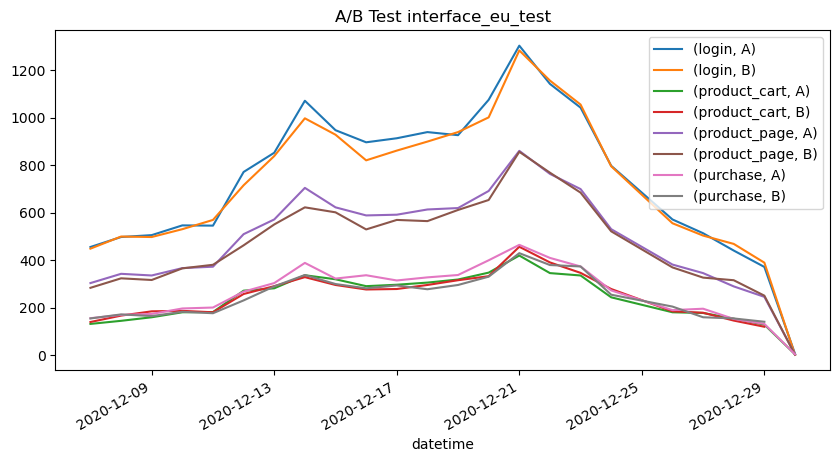

In [201]:
#plt.figure(figsize=(10,5))
#sns.lineplot(data= pivot_daily_event.loc[:,'interface_eu_test']['A'])
#sns.lineplot(data= pivot_daily_event.loc[:,'interface_eu_test'].reset_index(), x='datetime', y='group') 
pivot_daily_event.loc[:,'interface_eu_test'].reset_index().plot(kind='line', x='datetime',
                                                               figsize=(10,5))

plt.legend()
plt.title('A/B Test interface_eu_test')
#plt.ylim(0,2500)

jika dilihat dari visualisasi data, dominan grup A lebih tinggi daripada grup B pada testname interface_eu_test

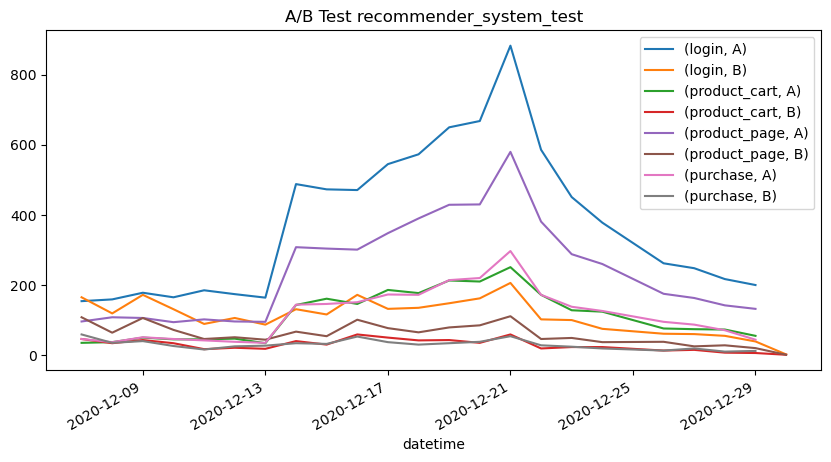

In [202]:
#plt.figure(figsize=(10,5))


#sns.lineplot(data= df_a_recommender_daily,
             #x='datetime', y='user_id', hue='event_name',)

#sns.lineplot(data=df_b_recommender_daily,
             #x='datetime', y='user_id', hue='event_name')

pivot_daily_event.loc[:,'recommender_system_test'].reset_index().plot(kind='line', x='datetime',
                                                               figsize=(10,5))
plt.legend()
plt.title('A/B Test recommender_system_test')
plt.show()
#plt.ylim(0,2500)

pada testname recommender_system_test juga grup A lebih tinggi, tetapi jika di testname ini wajar jila A lebih tinggi karena jumlah partisipan pada test ini memiliki perbedaan yang signifikan

In [203]:
df_merge_all[df_merge_all['datetime'] == '2020-12-14']['day'].value_counts()

day
0    6138
Name: count, dtype: int64

In [204]:
df_merge_all[df_merge_all['datetime'] == '2020-12-21']['day'].value_counts()

day
0    8511
Name: count, dtype: int64

dari tabel diatas didapati hasil bahwa pada hari senin menunjukkan hari puncak pembelian

## A/B Testing

In [205]:
#membuat pivot berisikan jumlah partisipan yang melalui funnel
user_pivot = df_merge_all.pivot_table(
    index= 'event_name',
    values= 'user_id',
    columns= ['group','ab_test'],
    aggfunc= 'nunique')
user_pivot

group                        A                                         B  \
ab_test      interface_eu_test recommender_system_test interface_eu_test   
event_name                                                                 
login                     5466                    2747              5383   
product_cart              1756                     824              1812   
product_page              3639                    1780              3527   
purchase                  1931                     872              1782   

group                                 
ab_test      recommender_system_test  
event_name                            
login                            927  
product_cart                     255  
product_page                     523  
purchase                         256

In [206]:
#membuat pivot berisikan total jumlah partisipan test
users_per_group = df_merge_all.pivot_table(
    index= 'ab_test',
    values= 'user_id',
    columns= 'group',
    aggfunc= 'nunique')
users_per_group

group,A,B
ab_test,,
interface_eu_test,5467,5383
recommender_system_test,2747,928


In [207]:
# fungsi dasar cek hipotesis
def check_hypothesis(succeses1, succeses2, trials1, trials2, alpha=0.05):
    #proporsi sukses di grup pertama
    p1 = succeses1 / trials1
    
    #proporsi sukses di grup kedua
    p2 = succeses2 / trials2
    
    #proporsi kombinasi
    p_combined = (succeses1 + succeses2) / (trials1 + trials2)
    
    #perbedaan proporsi
    difference= p1-p2
    
    #perhitungan statistik dengan normal deviasi di distribusi normal
    z_value= difference / math.sqrt(p_combined * (1 - p_combined) * (1/trials1 + 1/trials2))
    
    #setting normal distribusi 
    distr = stats.norm(0,1)
    
    #perhitungan statistik dengan normal deviasi di distribusi normal
    z_value= difference / math.sqrt(p_combined * (1 - p_combined) * (1/trials1 + 1/trials2))
    
    p_value = (1 - distr.cdf(abs(z_value))) *2
    
    print('pvalue: ',p_value)
    
    if (p_value < alpha):
        print("Menolak Hipotesis 0, terdapat perbedaan signifikan diantara proporsi")
    else:
        print("Gagal Menolak Hipotesis 0, tidak terdapat perbedaan yang signifikan antara proporsi")
        
    

In [208]:
# fungsi cek hipotesis semua event di 2 kelompok dan 2 testname
def check_event_hypothesis(user_pivot, users_per_group, event, exp1, exp2, ab_test1, ab_test2):
    frac1= user_pivot.loc[event, exp1][ab_test1] / users_per_group.loc[ab_test1, exp1]
    frac2= user_pivot.loc[event, exp2][ab_test2] / users_per_group.loc[ab_test2, exp2]    
    
    print(f' {frac1} dengan event {event} di grup {exp1} dengan testname {ab_test1}')
    print(f' {frac2} dengan event {event} di grup {exp2} dengan testname {ab_test2}')
    
    check_hypothesis(user_pivot.loc[event, exp1][ab_test1],
                 user_pivot.loc[event, exp2][ab_test2],
                 users_per_group.loc[ab_test1, exp1],
                 users_per_group.loc[ab_test2, exp2],
                )

In [209]:
# A/B Testing pada testname interface_eu_test
for event in user_pivot.index:
        check_event_hypothesis(user_pivot, users_per_group, event, 'A','B', 'interface_eu_test', 'interface_eu_test')
        print()

 0.9998170843241265 dengan event login di grup A dengan testname interface_eu_test
 1.0 dengan event login di grup B dengan testname interface_eu_test
pvalue:  0.32103485047255065
Gagal Menolak Hipotesis 0, tidak terdapat perbedaan yang signifikan antara proporsi

 0.32119992683372967 dengan event product_cart di grup A dengan testname interface_eu_test
 0.3366152702953743 dengan event product_cart di grup B dengan testname interface_eu_test
pvalue:  0.08746918913258162
Gagal Menolak Hipotesis 0, tidak terdapat perbedaan yang signifikan antara proporsi

 0.665630144503384 dengan event product_page di grup A dengan testname interface_eu_test
 0.6552108489689764 dengan event product_page di grup B dengan testname interface_eu_test
pvalue:  0.2518419682737163
Gagal Menolak Hipotesis 0, tidak terdapat perbedaan yang signifikan antara proporsi

 0.35321017011157857 dengan event purchase di grup A dengan testname interface_eu_test
 0.3310421697937953 dengan event purchase di grup B dengan te

In [210]:
# A/B Testing pada testname recommender_system_test
for event in user_pivot.index:
        check_event_hypothesis(user_pivot, users_per_group, event, 'A','B', 'recommender_system_test', 'recommender_system_test')
        print()

 1.0 dengan event login di grup A dengan testname recommender_system_test
 0.9989224137931034 dengan event login di grup B dengan testname recommender_system_test
pvalue:  0.08529860212027773
Gagal Menolak Hipotesis 0, tidak terdapat perbedaan yang signifikan antara proporsi

 0.2999635966508919 dengan event product_cart di grup A dengan testname recommender_system_test
 0.27478448275862066 dengan event product_cart di grup B dengan testname recommender_system_test
pvalue:  0.14534814557238196
Gagal Menolak Hipotesis 0, tidak terdapat perbedaan yang signifikan antara proporsi

 0.6479796141244994 dengan event product_page di grup A dengan testname recommender_system_test
 0.5635775862068966 dengan event product_page di grup B dengan testname recommender_system_test
pvalue:  4.310980554755872e-06
Menolak Hipotesis 0, terdapat perbedaan signifikan diantara proporsi

 0.3174372042227885 dengan event purchase di grup A dengan testname recommender_system_test
 0.27586206896551724 dengan eve

## Kesimpulan

Setelah dilakukan analisis terdapat kesimpulan antara lain:
1. mayoritas kesalahan tipe data pada dataframe adalah dibagian tanggal. 
2. perbedaan yang signifikan pada jumlah user antara kelompok kontrol dan uji (kolom "recommender_system_test")
3. adanya user yang tidak independen (berada di kedua grup kontrol dan uji)
4. selama 2 minggu melakukan analisa didapati pelanggan biasanya berbelanja di awal minggu
5. pada name interface_eu_test, ratio di event purchase terdapat perbedaan 2% dengan kelompok B lebih rendah 
6. pada testname recommender_system_test,  ratio antar event berbeda 2-8% dengan kelompok B lebih rendah. bisa disimpulkan ternyata pada kelompok uji memiliki ratio lebih rendah daripada kelompok kontrol
7. pada testname interface_eu_test di event purchase terdapat perbedaan perbedaan yang signifikan antara proporsi
8. pada testname recommender_system_test terdapat perbedaan signifikan di event product_page dan purchase




